# As discussões realizadas aqui são baseadas nos dados entregues e buscas simples no buscador e no Trends da google. 

In [1]:
!pip install -U pip setuptools wheel
!pip install -U spacy
!python -m spacy download pt_core_news_sm

     |████████████████████████████████| 22.1 MB 2.0 MB/s eta 0:00:01


✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')


In [1]:
!pip install xlrd==1.1.0
#!pip install gensim==3.4.0
!pip install scikit-learn==0.19.1
!pip install seaborn==0.8

In [2]:
import pandas as pd
df1 = pd.read_csv('elo7_recruitment_dataset.csv')

In [3]:
from sklearn.model_selection import train_test_split

def split_stratified_into_train_val_test(df_input, stratify_colname='y',
                                         frac_train=0.6, frac_val=0.15, frac_test=0.25,
                                         random_state=None):
    '''
    Splits a Pandas dataframe into three subsets (train, val, and test)
    following fractional ratios provided by the user, where each subset is
    stratified by the values in a specific column (that is, each subset has
    the same relative frequency of the values in the column). It performs this
    splitting by running train_test_split() twice.

    Parameters
    ----------
    df_input : Pandas dataframe
        Input dataframe to be split.
    stratify_colname : str
        The name of the column that will be used for stratification. Usually
        this column would be for the label.
    frac_train : float
    frac_val   : float
    frac_test  : float
        The ratios with which the dataframe will be split into train, val, and
        test data. The values should be expressed as float fractions and should
        sum to 1.0.
    random_state : int, None, or RandomStateInstance
        Value to be passed to train_test_split().

    Returns
    -------
    df_train, df_val, df_test :
        Dataframes containing the three splits.
    '''

    if frac_train + frac_val + frac_test != 1.0:
        raise ValueError('fractions %f, %f, %f do not add up to 1.0' % \
                         (frac_train, frac_val, frac_test))

    if stratify_colname not in df_input.columns:
        raise ValueError('%s is not a column in the dataframe' % (stratify_colname))

    X = df_input # Contains all columns.
    # y = category 
    y = df_input[[stratify_colname]] # Dataframe of just the column on which to stratify.

    # Split original dataframe into train and temp dataframes.
    df_train, df_temp, y_train, y_temp = train_test_split(X,
                                                          y,
                                                          stratify=y,
                                                          test_size=(1.0 - frac_train),
                                                          random_state=random_state)

    # Split the temp dataframe into val and test dataframes.
    relative_frac_test = frac_test / (frac_val + frac_test)
    df_val, df_test, y_val, y_test = train_test_split(df_temp,
                                                      y_temp,
                                                      stratify=y_temp,
                                                      test_size=relative_frac_test,
                                                      random_state=random_state)

    assert len(df_input) == len(df_train) + len(df_val) + len(df_test)

    return df_train, df_val, df_test

In [5]:
train, validate, test = split_stratified_into_train_val_test(df1, stratify_colname='category')

In [6]:
import re  # For preprocessing
import pandas as pd  # For data handling
from time import time  # To time our operations
from collections import defaultdict  # For word frequency

import spacy  # For preprocessing

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [ ]:
!python -m spacy download pt_core_news_sm

In [10]:
nlp = spacy.load('pt_core_news_sm')

/home/paulinha/anaconda3/envs/susan/lib/python3.6/site-packages/spacy/util.py:275: UserWarning: [W031] Model 'pt_core_news_sm' (3.0.0) requires spaCy v3.0 and is incompatible with the current spaCy version (2.3.5). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


KeyError: "[E002] Can't find factory for 'tok2vec'. This usually happens when spaCy calls `nlp.create_pipe` with a component name that's not built in - for example, when constructing the pipeline from a model's meta.json. If you're using a custom component, you can write to `Language.factories['tok2vec']` or remove it from the model meta and add it via `nlp.add_pipe` instead."

In [7]:
df1.shape

(38507, 15)

In [8]:
df = df1[["category", "title"]]

In [77]:
df.head(2)

,category,title
0,Decoração,Mandala Espírito Santo
1,Papel e Cia,Cartão de Visita


In [78]:
df.isnull().sum()

category    0
title       0
dtype: int64

In [79]:
nlp = spacy.load('pt_core_news_sm') # disabling Named Entity Recognition for speed
#, disable=['ner', 'parser']
def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)

In [80]:
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in df['title'])

In [81]:
brief_cleaning

<generator object <genexpr> at 0x7fa95d115c50>

In [82]:
brief_cleaning

<generator object <genexpr> at 0x7fa95d115c50>

In [83]:
t = time()

txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning)]

print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 0.47 mins


In [84]:
brief_cleaning

<generator object <genexpr> at 0x7fa95d115c50>

In [85]:
df_clean = pd.DataFrame({'clean': txt})
#df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

(38507, 1)

In [86]:
df_clean.head(200)

,clean
0,mandala esp rito santo
1,None
2,organizador expositor p esmalte
3,jogar len ol ber estampar
4,adesivo box banheiro
...,...
195,lembrancinha festa ano parir temer
196,quadrar decorativo sala beijar flor
197,r gua caixa leite quadrar curvo patchwork f gr...
198,tubete aplicar gato


In [87]:
import gensim
from gensim.models.phrases import Phrases, Phraser

In [88]:
  
sent = []    
for row in df_clean['clean']:
    if row is None:
        continue
    sent.append(row.split())    


In [89]:
phrases = Phrases(sent, min_count=30, progress_per=10000)

INFO - 23:55:45: collecting all words and their counts
INFO - 23:55:45: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 23:55:45: PROGRESS: at sentence #10000, processed 43982 words and 18020 word types
INFO - 23:55:45: PROGRESS: at sentence #20000, processed 87660 words and 28160 word types
INFO - 23:55:45: PROGRESS: at sentence #30000, processed 131711 words and 35808 word types
INFO - 23:55:45: collected 36881 word types from a corpus of 139016 words (unigram + bigrams) and 31657 sentences
INFO - 23:55:45: using 36881 counts as vocab in Phrases<0 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000>


In [90]:
bigram = Phraser(phrases)

INFO - 23:55:45: source_vocab length 36881
INFO - 23:55:46: Phraser built with 137 137 phrasegrams


In [91]:
sentences = bigram[sent]

In [92]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

5231

In [93]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['personalizar',
 'lembrancinha',
 'kit',
 'dia_pai',
 'beb',
 'caixa',
 'caneca',
 'maternidade',
 'm',
 'quadrar']

In [123]:
word_freq

defaultdict(int,
            {'mandala': 69,
             'esp_rito': 31,
             'santo': 93,
             'organizador': 142,
             'expositor': 16,
             'p': 460,
             'esmalte': 4,
             'jogar': 177,
             'len': 43,
             'ol': 27,
             'ber': 442,
             'estampar': 59,
             'adesivo': 934,
             'box_banheiro': 40,
             'lbum_figura': 71,
             'dia_pai': 2653,
             'arranjar_florir': 57,
             'orquidias': 2,
             'kit': 2938,
             'aromarizador': 2,
             'sacola': 321,
             'lembrancinha': 3598,
             'maternidade': 1111,
             'chaveiro': 711,
             'mantar': 188,
             'beb': 1580,
             'personalizar': 4941,
             'nuvem': 282,
             'nome': 299,
             'crach': 13,
             'cord': 37,
             'portar': 924,
             'arte': 103,
             'gr_til': 23,
           

In [94]:
#import multiprocessing

from gensim.models import Word2Vec

In [95]:
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20
                     )

In [96]:
t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 23:55:46: collecting all words and their counts
INFO - 23:55:46: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 23:55:47: PROGRESS: at sentence #10000, processed 39185 words, keeping 3368 word types
INFO - 23:55:47: PROGRESS: at sentence #20000, processed 78123 words, keeping 4469 word types
INFO - 23:55:47: PROGRESS: at sentence #30000, processed 117375 words, keeping 5136 word types
INFO - 23:55:47: collected 5231 word types from a corpus of 123875 raw words and 31657 sentences
INFO - 23:55:47: Loading a fresh vocabulary
INFO - 23:55:47: min_count=20 retains 904 unique words (17% of original 5231, drops 4327)
INFO - 23:55:47: min_count=20 leaves 107339 word corpus (86% of original 123875, drops 16536)
INFO - 23:55:47: deleting the raw counts dictionary of 5231 items
INFO - 23:55:47: sample=6e-05 downsamples 904 most-common words
INFO - 23:55:47: downsampling leaves estimated 26412 word corpus (24.6% of prior 107339)
INFO - 23:55:47: estimated required

Time to build vocab: 0.01 mins


In [97]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 23:55:47: training model with 3 workers on 904 vocabulary and 300 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2
INFO - 23:55:48: worker thread finished; awaiting finish of 2 more threads
INFO - 23:55:48: worker thread finished; awaiting finish of 1 more threads
INFO - 23:55:48: worker thread finished; awaiting finish of 0 more threads
INFO - 23:55:48: EPOCH - 1 : training on 123875 raw words (26358 effective words) took 0.7s, 36449 effective words/s
INFO - 23:55:49: worker thread finished; awaiting finish of 2 more threads
INFO - 23:55:49: worker thread finished; awaiting finish of 1 more threads
INFO - 23:55:49: worker thread finished; awaiting finish of 0 more threads
INFO - 23:55:49: EPOCH - 2 : training on 123875 raw words (26360 effective words) took 0.8s, 33144 effective words/s
INFO - 23:55:50: worker thread finished; awaiting finish of 2 more threads
INFO - 23:55:50: worker thread finished; awaiting finish of 1 more threads
INFO - 23:55:50: worker thread fi

INFO - 23:56:06: EPOCH - 24 : training on 123875 raw words (26333 effective words) took 0.7s, 35422 effective words/s
INFO - 23:56:07: worker thread finished; awaiting finish of 2 more threads
INFO - 23:56:07: worker thread finished; awaiting finish of 1 more threads
INFO - 23:56:07: worker thread finished; awaiting finish of 0 more threads
INFO - 23:56:07: EPOCH - 25 : training on 123875 raw words (26388 effective words) took 0.8s, 34642 effective words/s
INFO - 23:56:08: worker thread finished; awaiting finish of 2 more threads
INFO - 23:56:08: worker thread finished; awaiting finish of 1 more threads
INFO - 23:56:08: worker thread finished; awaiting finish of 0 more threads
INFO - 23:56:08: EPOCH - 26 : training on 123875 raw words (26245 effective words) took 0.8s, 32990 effective words/s
INFO - 23:56:09: worker thread finished; awaiting finish of 2 more threads
INFO - 23:56:09: worker thread finished; awaiting finish of 1 more threads
INFO - 23:56:09: worker thread finished; await

Time to train the model: 0.4 mins


In [98]:
w2v_model.init_sims(replace=True)

INFO - 23:56:11: precomputing L2-norms of word weight vectors


In [99]:
df['category']

0            Decoração
1          Papel e Cia
2               Outros
3                 Bebê
4            Decoração
             ...      
38502        Decoração
38503    Lembrancinhas
38504    Lembrancinhas
38505    Lembrancinhas
38506    Lembrancinhas
Name: category, Length: 38507, dtype: object

In [100]:
df['category'].drop_duplicates()

0              Decoração
1            Papel e Cia
2                 Outros
3                   Bebê
5          Lembrancinhas
21    Bijuterias e Jóias
Name: category, dtype: object

# classes
['personalizar',
 'kit',
 'lembrancinha',
 'caixa',
 'm',
 'adesivo',
 'dia_pai',
 'quadrar',
 'beb',
 'portar']

In [56]:
print(w2v_model.wv)

In [66]:
from gensim.test.utils import datapath

In [68]:
similarities = w2v_model.wv.evaluate_word_pairs(test[['category', 'title']])

KeyError: 'personalizar'

In [ ]:
model = KeyedVectors.load_word2vec_format('cbow_s300.txt')

In [101]:
w2v_model.wv.most_similar(positive=["kit"])

[('menino', 0.9941595196723938),
 ('maternidade', 0.9926939606666565),
 ('pe', 0.9912391901016235),
 ('urso', 0.9903022050857544),
 ('malo', 0.9896935820579529),
 ('beb', 0.9896042346954346),
 ('ch', 0.9893273115158081),
 ('luxar', 0.988660454750061),
 ('beber', 0.9875938296318054),
 ('bolsar_maternidade', 0.9874415397644043)]

In [102]:
w2v_model.wv.most_similar(positive=["personalizar"])

[('caneca', 0.9865725040435791),
 ('lembrancinha', 0.9856938719749451),
 ('dia_pai', 0.9855821132659912),
 ('ml', 0.9852269887924194),
 ('ano', 0.9837863445281982),
 ('copar', 0.9804685115814209),
 ('festa', 0.9803849458694458),
 ('lembran', 0.9791412353515625),
 ('anivers_rir', 0.9766266345977783),
 ('lembrancinhas', 0.9743517637252808)]

In [103]:
w2v_model.wv.most_similar(positive=["lembrancinha"])

[('lembran', 0.988865852355957),
 ('caneca', 0.987989604473114),
 ('batizado', 0.9859635829925537),
 ('personalizar', 0.9856938719749451),
 ('ano', 0.9839491248130798),
 ('lembrancinhas', 0.98373943567276),
 ('dia_pai', 0.9830625057220459),
 ('festa', 0.9829208850860596),
 ('ch', 0.9813867807388306),
 ('anivers_rir', 0.9803107976913452)]

In [104]:
w2v_model.wv.most_similar(positive=["caixa"])

[('padrinho', 0.996832013130188),
 ('lembran', 0.9949718713760376),
 ('convite_padrinho', 0.9946987628936768),
 ('surpreso', 0.9945613145828247),
 ('anivers_rir', 0.9943182468414307),
 ('batizado', 0.9933123588562012),
 ('batismo', 0.9931552410125732),
 ('papar', 0.9930397868156433),
 ('vov', 0.9928380846977234),
 ('foto', 0.9927669763565063)]

In [105]:
w2v_model.wv.most_similar(positive=["m"])

[('alian', 0.9877783060073853),
 ('anel', 0.9871493577957153),
 ('solit', 0.9839441776275635),
 ('moeda_antigo', 0.9834151268005371),
 ('compromisso', 0.9801010489463806),
 ('noivar', 0.9785270094871521),
 ('ourar_k', 0.9735758304595947),
 ('k', 0.9723803997039795),
 ('folhear_ourar', 0.9714864492416382),
 ('prata', 0.9701671600341797)]

In [106]:
w2v_model.wv.most_similar(positive=["adesivo"])

[('d', 0.9967816472053528),
 ('parede', 0.9961715936660767),
 ('quadro', 0.9950670599937439),
 ('x_cm', 0.99479740858078),
 ('arvorar', 0.9946721196174622),
 ('moldurar', 0.994659960269928),
 ('f', 0.9941283464431763),
 ('mosaico', 0.9940853118896484),
 ('box_banheiro', 0.9940500259399414),
 ('vidrar', 0.9937998056411743)]

In [107]:
w2v_model.wv.most_similar(positive=["dia_pai"])

[('caneca', 0.9947811961174011),
 ('presentar', 0.9912503957748413),
 ('pai', 0.9864961504936218),
 ('personalizar', 0.9855821132659912),
 ('lembran', 0.9849537014961243),
 ('ano', 0.9844200015068054),
 ('lembrancinha', 0.9830625057220459),
 ('caixa', 0.9830535650253296),
 ('anivers_rir', 0.9812407493591309),
 ('padrinho', 0.9803450107574463)]

In [108]:
w2v_model.wv.most_similar(positive=["quadrar"])

[('moderno', 0.9960378408432007),
 ('abstrato', 0.9959717988967896),
 ('pintura_tela', 0.9955025315284729),
 ('decorativo', 0.9946986436843872),
 ('moldurar', 0.9932742118835449),
 ('paisagem', 0.9920178651809692),
 ('sala', 0.9901927709579468),
 ('tela', 0.9892183542251587),
 ('poster', 0.9890654683113098),
 ('quadro', 0.9889299273490906)]

In [109]:
w2v_model.wv.most_similar(positive=["beb"])

[('menino', 0.997063159942627),
 ('beber', 0.9943947196006775),
 ('urso', 0.9938689470291138),
 ('maternidade', 0.9931271076202393),
 ('pe', 0.9921184182167053),
 ('malo', 0.990486741065979),
 ('bolsar', 0.9901354312896729),
 ('kit_higiene', 0.9897885322570801),
 ('ch', 0.9897420406341553),
 ('kit', 0.9896042346954346)]

In [110]:
w2v_model.wv.most_similar(positive=["portar"])

[('bailarino', 0.9969887733459473),
 ('mdf_cru', 0.9969475269317627),
 ('celular', 0.9969010353088379),
 ('guardanapo', 0.9967451691627502),
 ('aviador', 0.9966501593589783),
 ('t_rmica', 0.996533989906311),
 ('guirlanda', 0.9965253472328186),
 ('centrar_mesa', 0.9965243935585022),
 ('pequeno', 0.9965001344680786),
 ('principe', 0.996484637260437)]

In [111]:
w2v_model.wv.similarity("lembrancinhas", 'lata')

0.9974582349056785

In [112]:
w2v_model.wv.doesnt_match(['dinossauro', 'portar', 'ovelhinha'])

/home/paulinha/anaconda3/envs/susan/lib/python3.6/site-packages/gensim/models/keyedvectors.py:730: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'portar'

In [113]:
w2v_model.wv.most_similar(positive=["portar", "dinossauro"], negative=["pe"], topn=3)

[('brindar', 0.9854601621627808),
 ('profiss', 0.9853772521018982),
 ('negro', 0.9852868318557739)]

In [114]:
!pip install seaborn --user --upgrade


In [115]:
import seaborn as sns
sns.set_style("dark")

In [116]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [117]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=50).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))
    

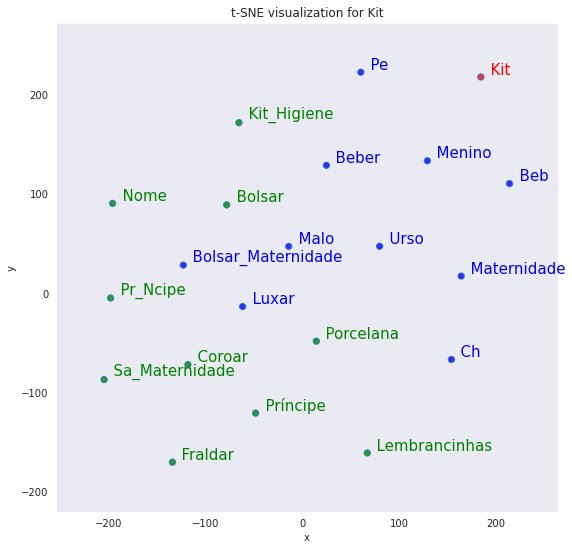

In [118]:
tsnescatterplot(w2v_model, "kit", [t[0] for t in w2v_model.wv.most_similar(positive=["kit"], topn=20)][10:])

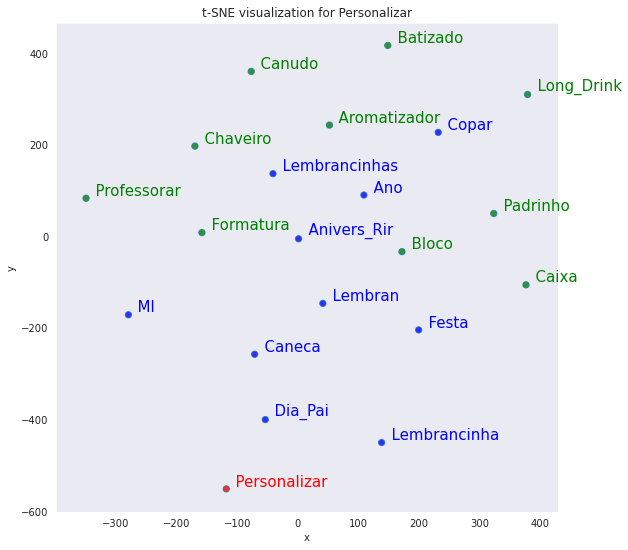

In [120]:
tsnescatterplot(w2v_model, "personalizar", [t[0] for t in w2v_model.wv.most_similar(positive=["personalizar"], topn=20)][10:])

# Assessórios para Casamento x Bijuterias 
Esse é outro caso o qual a classe casamento pode apresentar ações específicas e com a união de testes A/B podem rastrear o interesse específico, visto que noivas sempre buscam exclusividade e produtos personalizados com foco em casamento poderia ser separado de Bijuterias

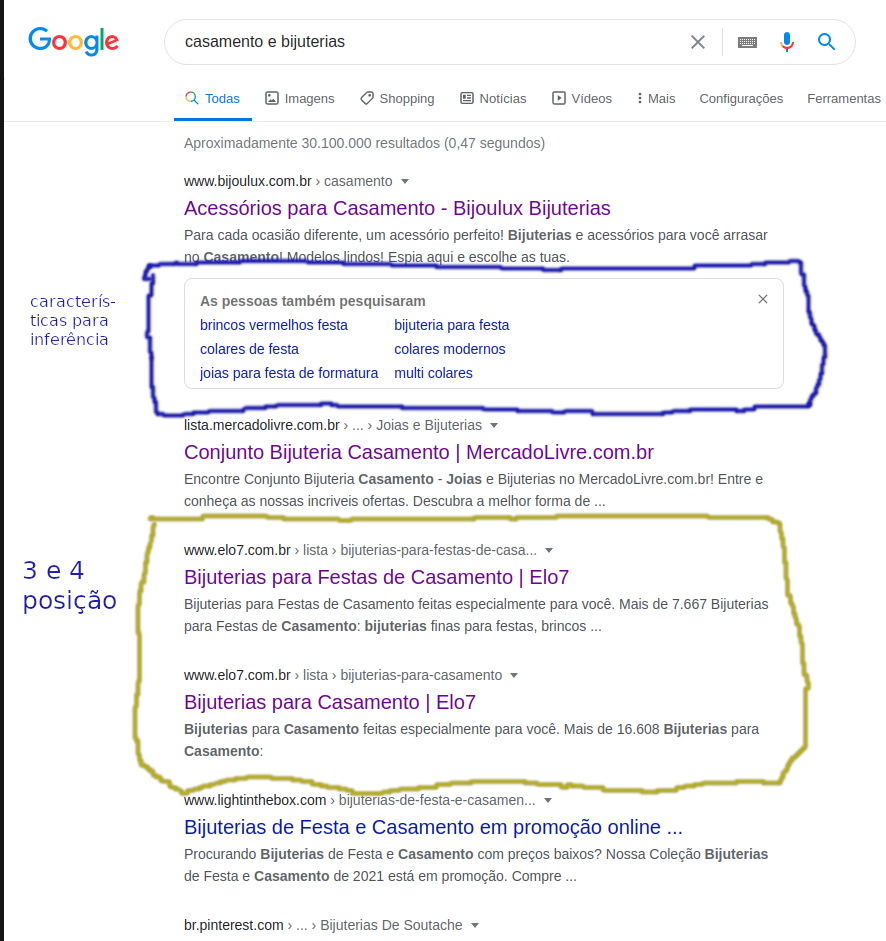

In [126]:
from IPython.display import Image
Image("ads_casamento.png")

# Vale a pena personalizar casamento?
Uma das premissas da metodologia scrum é a história. Então vamos pensar como uma noiva que não tem cadastro na **ELO7** ou **apresenta um acesso muito baixo na plataforma** e ainda a **renda média do Brasileiro**, como mostra a figura abaixo. Ao pensar nesse nicho e ainda no sonho de uma noiva, que mesmo com poucas possibilidades financeiras ela sempre sonhará com **um casamento personalizado** e aqui é onde a **Elo7** se diferência de mercado livre e bijoulux. O artesanato pode ter um custo menor e ainda essa noiva pode ser um novo atrativo para o **marketing** e aumentar a busca tanto no site como entre as vendas desses artesãos. 



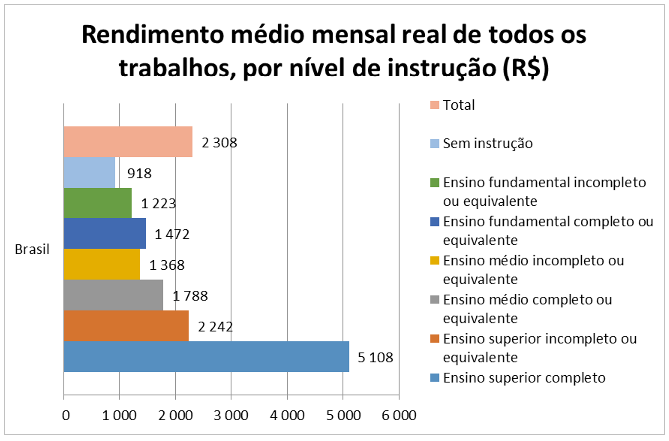

In [131]:
from IPython.display import Image
Image("rendimento.png")

### Bijoulux, Mercado Livre e Elo7, quem realmente apresenta um diferencial?

O Bijoulux e mercado livre apresentam os mesmo produtos seja a busca bijuterias, jóias ou casamento. Isso mostra que a provavelmente as tags, title ou categorias estão convergindo muito mais com as características apresentadas pelo Google, do que realmente apresentam **produtos personalizados como a ELO7**.

Ainda a risco dizer, somente com base em busca no site do mercado livre, que existem erros na categorização para casamento, e ainda na busca não há produtos com o diferencial da **ELO7** , e caso o tenha a plataforma ainda perece em personalizar melhor esse tipo de produto. Outro aspecto importante, é categorias como acessórios para veículos e materias escolares, sendo apresentados como próximas.

Podemos sugerir algumas hipóteses: (1) Categoria: Acessórios para veículos -> (i)Noivo, ele quer sair da igreja com um carro turbinado?; (ii) Ele quer alguma câmera interna para gravar os momentos (**até que plausível**); (iii) produtos de limpeza, brilho para carro 😊; (vi) um noivo(a) presenteando com uma jóia, aqui sim podemos talvez ter uma validação maior dessa categoria. Contudo, o diferencial da **Elo7** é um material personalizado que e pensar em categorias personalizadas é o diferencial com relação aos demais sites. Nesse contexto, a abordagem com categorias personalizadas pode ser o diferencial, entre as demais plataforma, pois penso **qual noiva não gostaria de obter um produto em seu casamento com um diferencial**




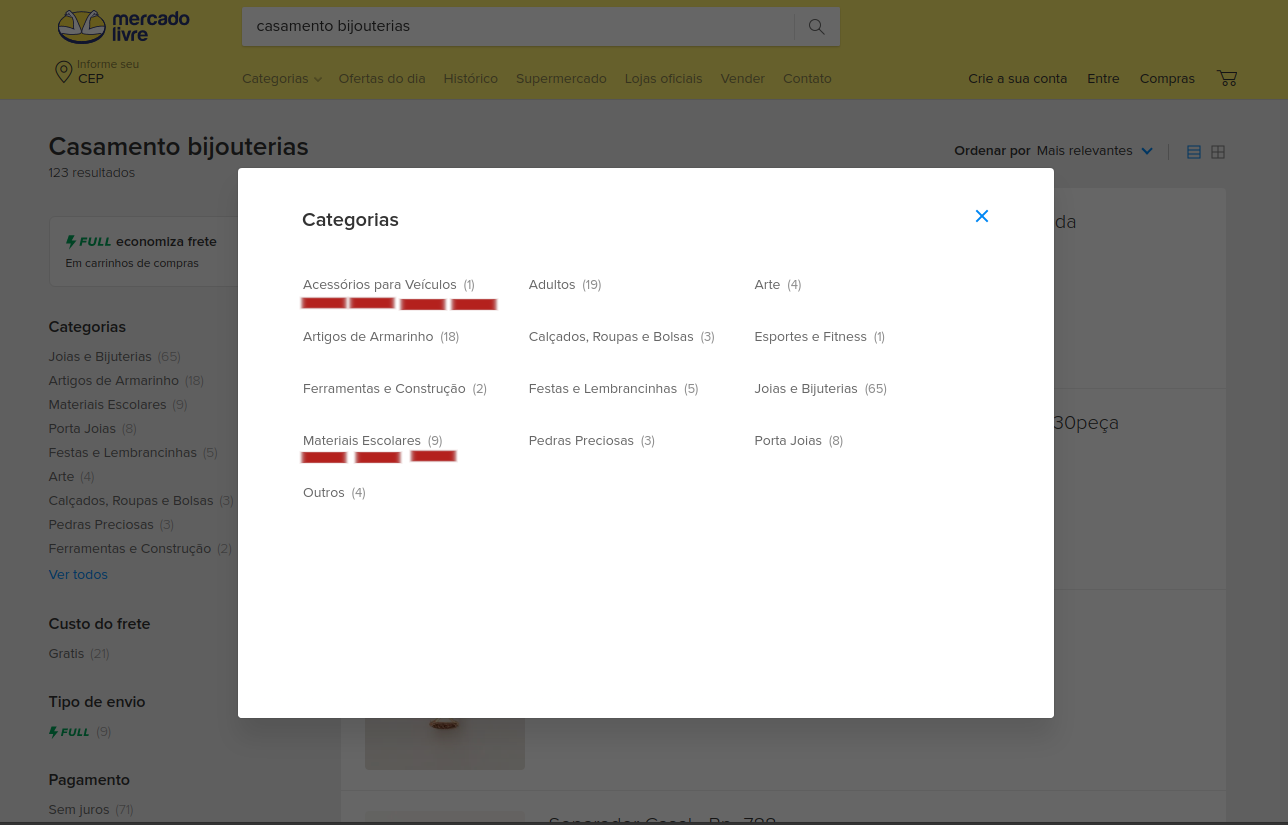

In [132]:
from IPython.display import Image
Image("ml_categorias.png")

## Como está hoje o site da Elo7 e como podemos melhorar

A busca no google foi **casamento bijuterias** a **ELO7** apresentou algum produto personalizado na terceira fileira. Caixas, brincos e corrente, podem ser também relacionados, mas o diferencial é a personalização e assim talvez esse produto poderia aparecer na primeira fileira, devido o direcionamento do **termo usado na busca**. 

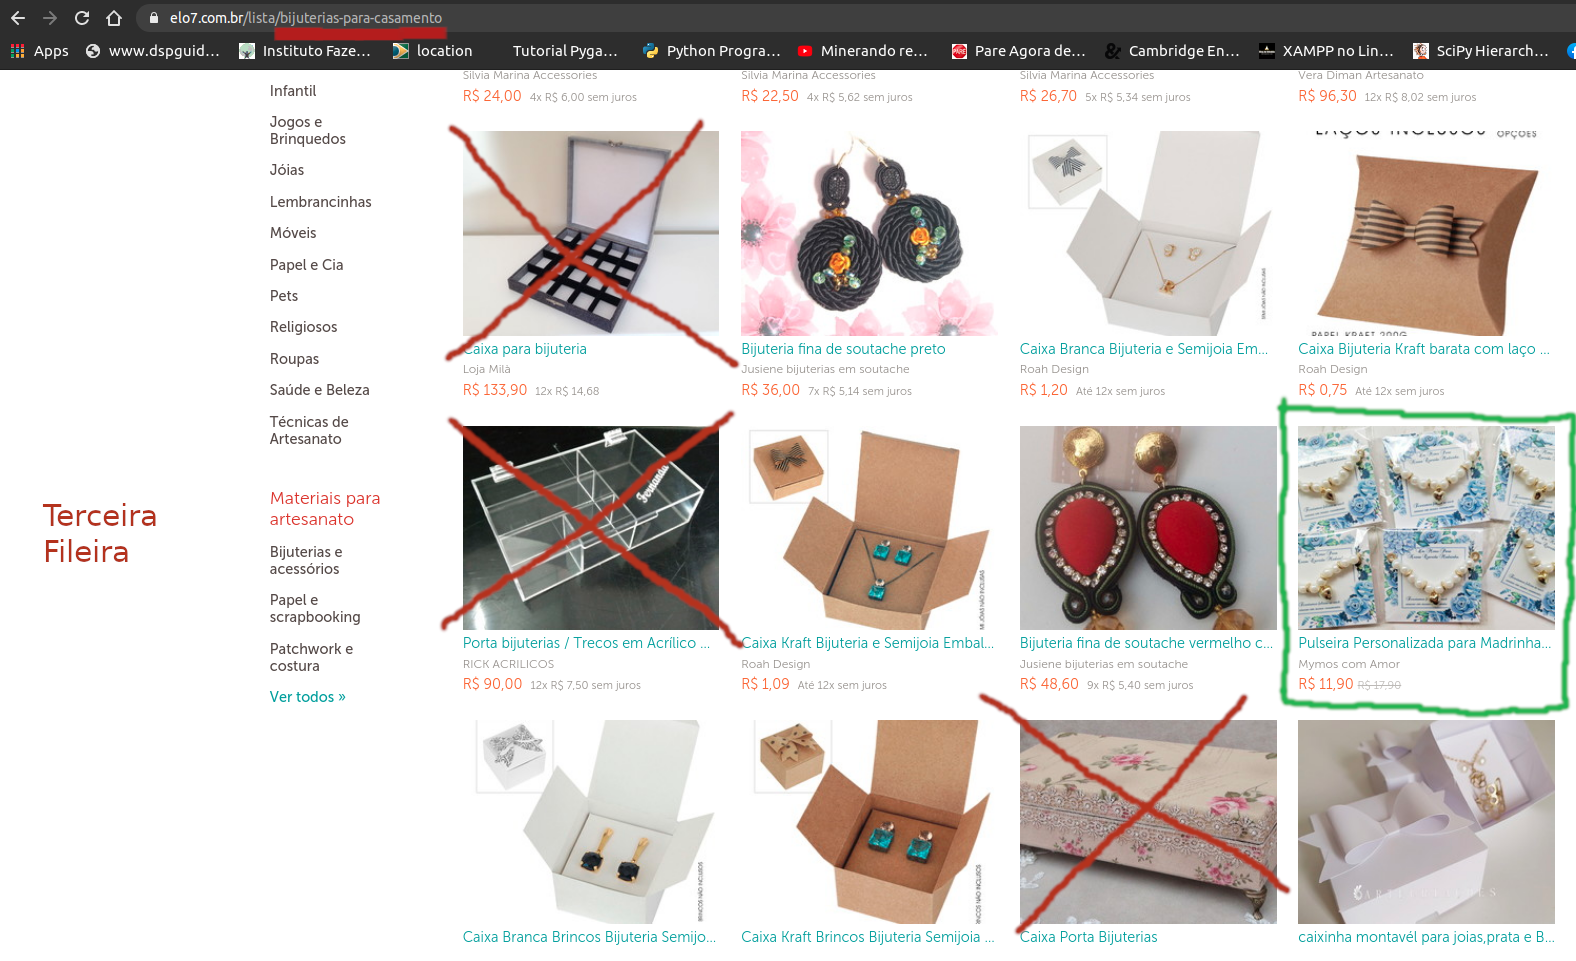

In [141]:
from IPython.display import Image
Image("biju_casamento.png")

## Busca Google Trends

**Qual termo (possível categoria) tem maior procura: casamento ou bijuteria e joias** 
Na figura abaixo podemos observar a importância desse setor, como uma categoria importante para e personalizada para a **ELO7**


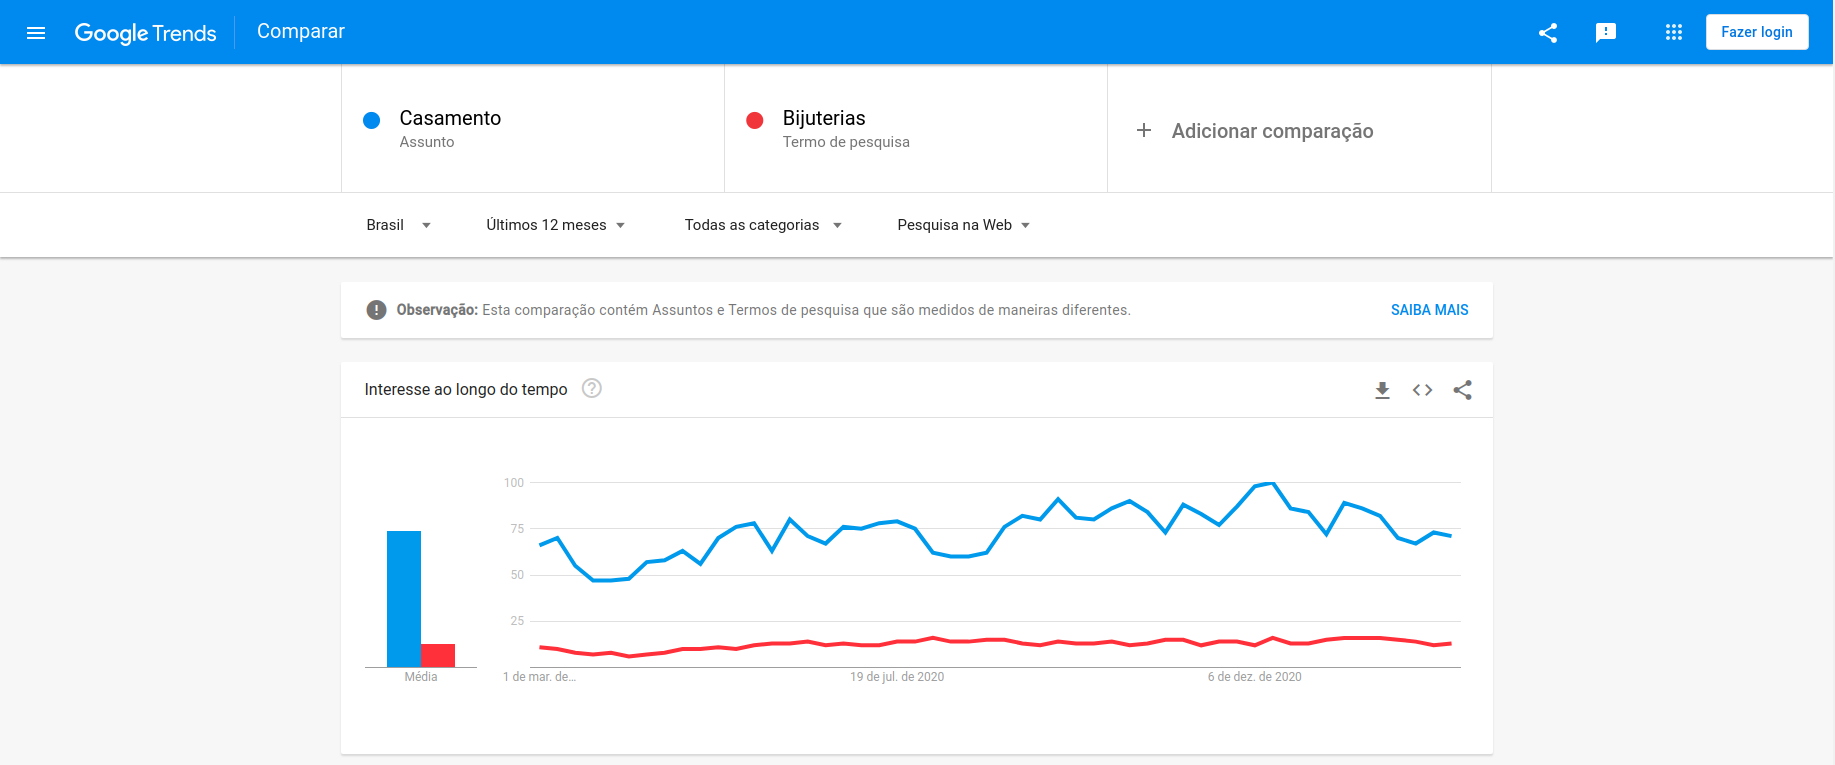

In [142]:
from IPython.display import Image
Image("termo_pesquisa.png")

## Ainda temos que com a base de dados fornecida, muitas palavras convergem com o buscador da google

Podemos destacar as palavras em amarelo e parcialmente com a palavra em laranja. Ainda, podemos inferir que palavras como aliança e noiva, apresentam maior proximidade vetorial com casamento (baseado na proximidade contextual)

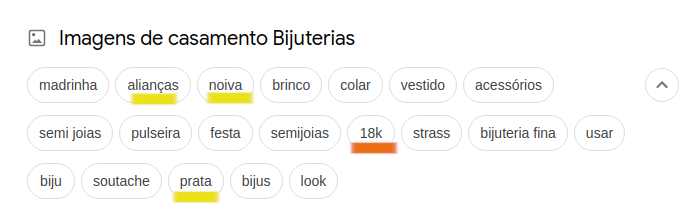

In [148]:
from IPython.display import Image
Image("palavras_google.png")

## Ainda podemos destacar os grupos com mais frequência

In [137]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import nltk

top_N = 20

words = word_freq

word_dist = nltk.FreqDist(word_freq)

stopwords = nltk.corpus.stopwords.words('portuguese')
words_except_stop_dist = nltk.FreqDist(w for w in words if w not in stopwords) 

print('All frequencies, including STOPWORDS:')
print('=' * 60)
rslt = pd.DataFrame(word_dist.most_common(top_N),
                    columns=['Word', 'Frequency'])
print(rslt)
print('=' * 60)

rslt = pd.DataFrame(words_except_stop_dist.most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')



All frequencies, including STOPWORDS:
            Word  Frequency
0   personalizar       4941
1   lembrancinha       3598
2            kit       2938
3        dia_pai       2653
4            beb       1580
5          caixa       1360
6         caneca       1299
7    maternidade       1111
8              m       1047
9        quadrar       1037
10        menino        939
11       adesivo        934
12        portar        924
13         festa        828
14             x        824
15         croch        810
16            ch        779
17           ano        765
18       lembran        740
19      chaveiro        711


## A alta similaridade entre o grupo

Apresentou maior similaridade com as seguintes palavras :

('alian', 0.9877783060073853), = aliança
 ('anel', 0.9871493577957153), = anel
 ('solit', 0.9839441776275635), = solitário
 ('moeda_antigo', 0.9834151268005371),= moeda antiga
 ('compromisso', 0.9801010489463806), = compromisso
 ('noivar', 0.9785270094871521),= noivar
 ('ourar_k', 0.9735758304595947),= ourar_quilates
 ('k', 0.9723803997039795),= quilates
 ('folhear_ourar', 0.9714864492416382),= folheados ourar
 ('prata', 0.9701671600341797)] = prata

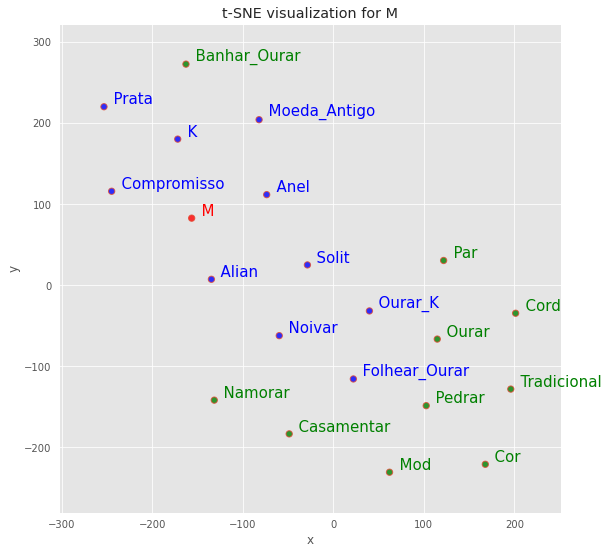

In [147]:
# m = casamento, 
tsnescatterplot(w2v_model, "m", [t[0] for t in w2v_model.wv.most_similar(positive=["m"], topn=20)][10:])

# E a convergência desses dados no mundo real

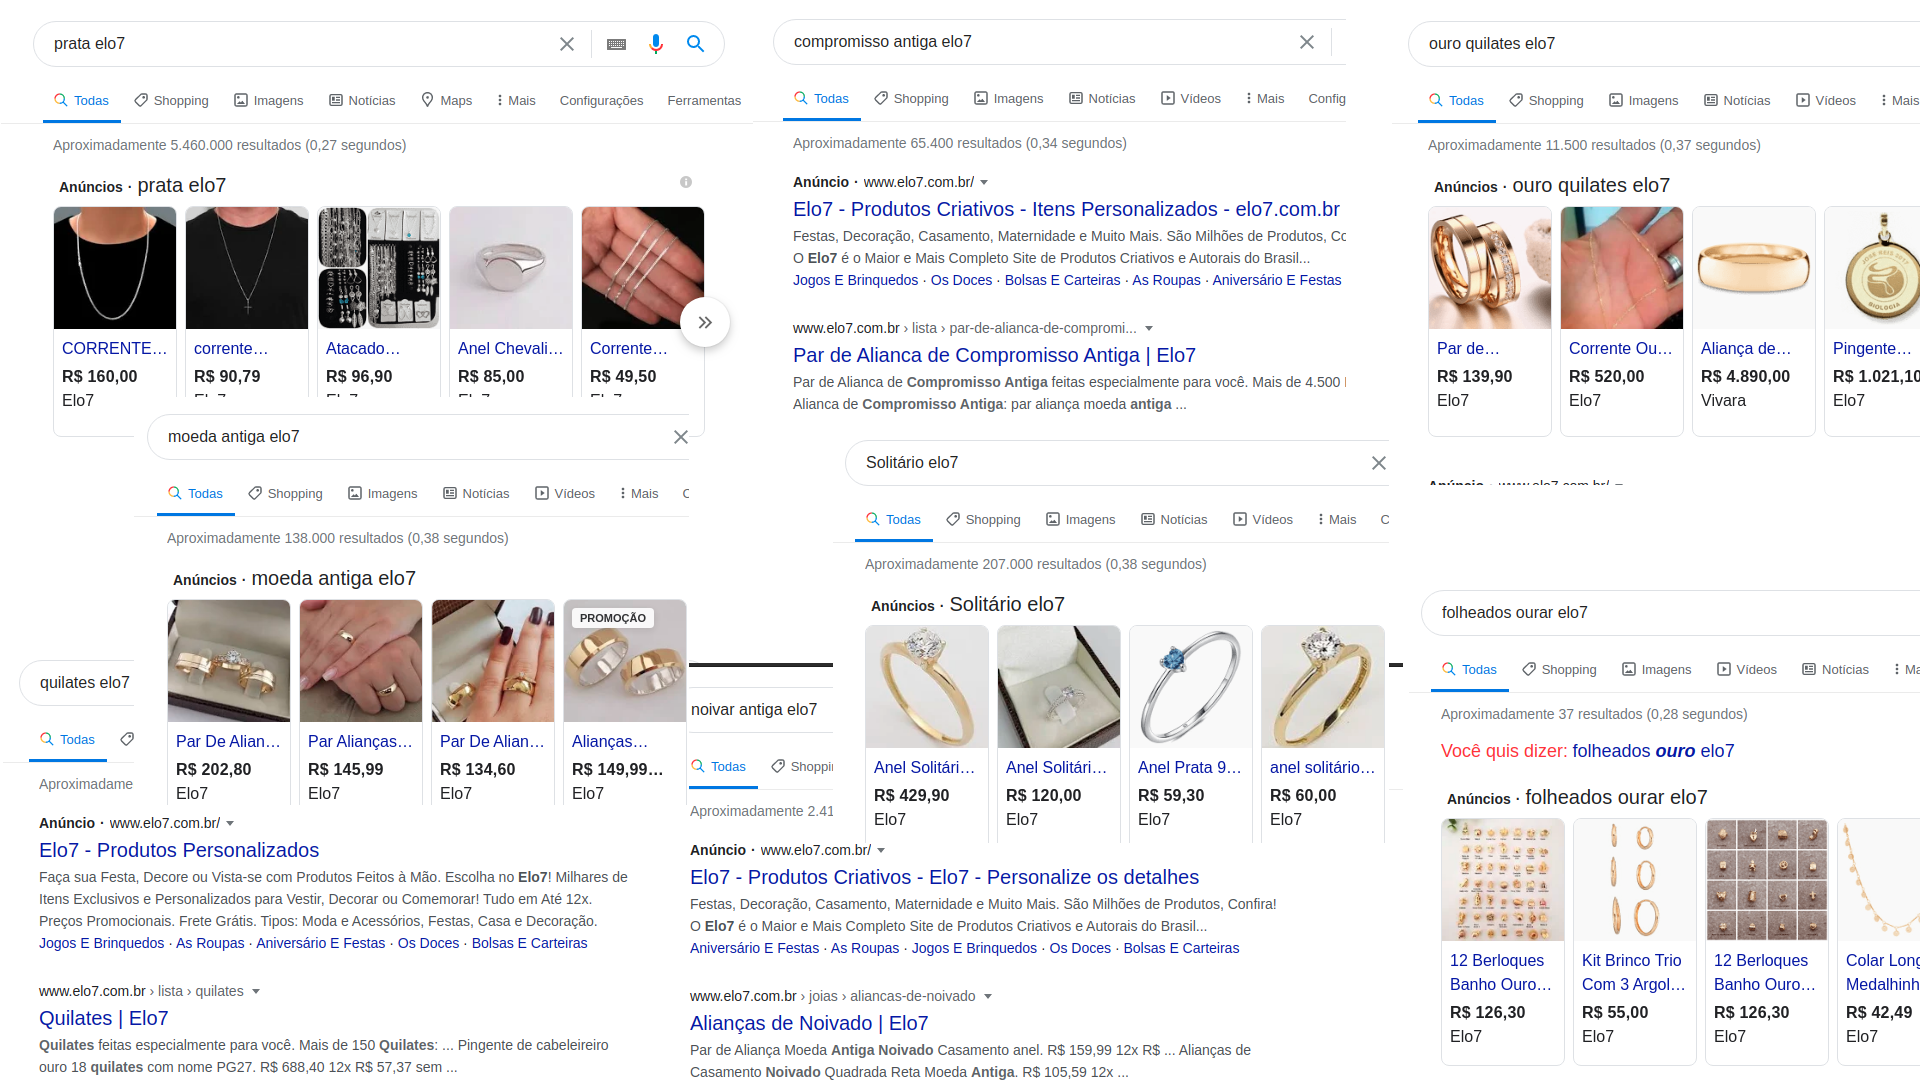

In [140]:
from IPython.display import Image
Image("teste_palavras.png")

## O que precisamos então ....

Reorganizar de forma personalizada a busca para aumentar a lead desses artesões. Com produtos de qualidade, preços acessíveis e que poderá atender o sonho de muitos casais, independemente da faixa salarial

## Mas será que esse é o fim da Bijuteria e joias ...

Não essa é somente a primeira parte, pois o google trends, também fornece dados de cidades, e assim os produtos podem ser apresentados com uma abordagem maior por regiões, seja categoria Bijuterias ou casamento, como mostra a imagem abaixo.
**Então podemos dizer que as cidades podem ser uma nova categoria?**
Não, mas esse dado regional, nos mostra que podemos podemos trabalhar com a categoria, em diferentes regiões.
Na imagem abaixo, podemos observar que a região norte e nordeste a categoria **casamento** é apresenta um possível bolsão de vendas para artesões com esse tipo de produto. Se observarmos casamento poderá agrupar com bodas, que amplia ainda mais as possíbilidades de venda desse artesão.

No entando, quando observamos a região sudeste e parte do nordeste a categoria **bijuteria** converge com o perfil de busca da região.

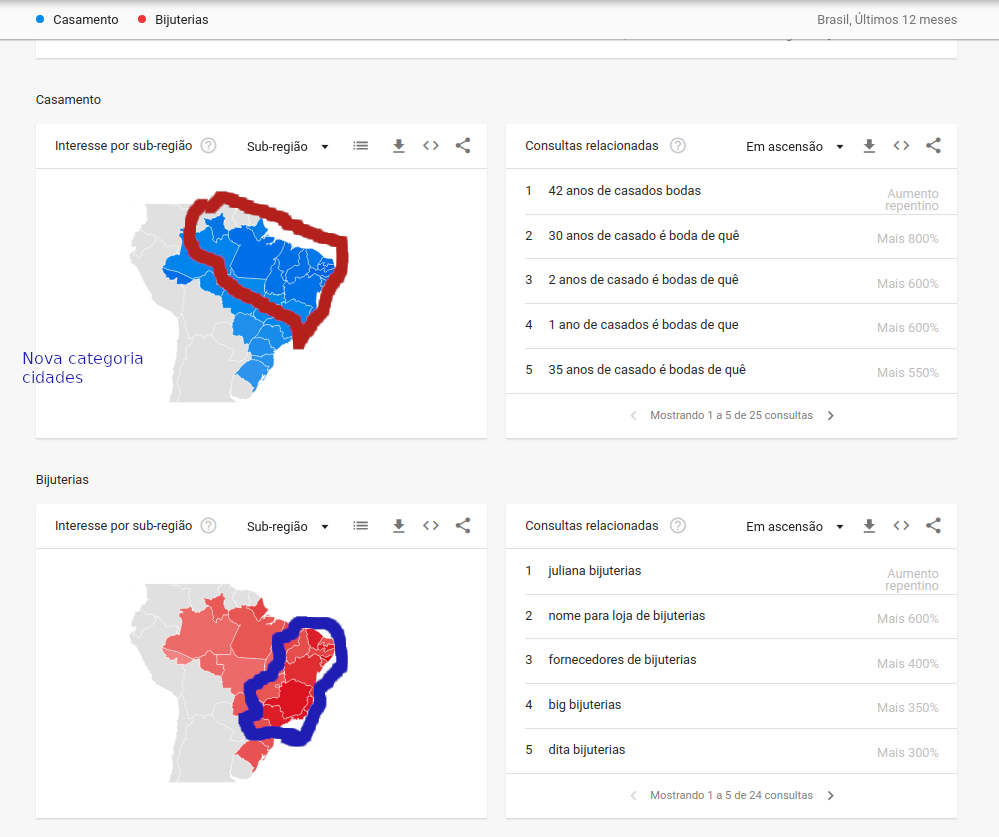

In [149]:
from IPython.display import Image
Image("cities.png")

## OK, o google trends nós mostrou um dado muito interessante, mas será que isso reflete a nossa base de dados?
No caso aqui não temos os dados das cidades para implementar um algoritmo de recomendação utilizando três possíveis possibilidades: distância euclidiana, cossenos ou jaccard.

Mas vamos pensar se houvesse a possibilidade de implementação, qual seria a finalidade da utilização da distância euclidiana?

Na região nordeste temos uma rede de artesões que produzem produtos personalizados e dentre esses produtos temos: noiva, madrinha, entre outros.

**Filtragem colaborativa** 
Joana é uma usuária da plataforma e queremos sugerir novos produtos, sendo assim como poderíamos realizar essa recomendação?

Com base nos dados inseridos na plataforma, poderíamos sugerir com base no endereço, cep ou bairro, assim com o tempo conseguiríamos observar padrões de compra entre usuários da região, a similaridade entre a busca de produtos e a avaliação dos produtos produzindo até scores que possibilitam observar a similaridade de compra entre os usuários.



# Vale ressaltar ...

Essa categoria **casamento** já está disponível dentro da plataforma da **ELO7**

## Então a análise feita não é valida?

**Não**, pois aqui vemos que dependendo da sua pergunta (hipótese nula) um mesmo dado poderá gerar diferentes resultados, por isso que uma das caracterśiticas de um cientista de dados deve ser o **pensamento analitíco**


In [ ]:
['personalizar',
 'lembrancinha',
 'kit',
 'dia_pai',
 'beb',
 'caixa',
 'caneca',
 'maternidade',
 'm',
 'quadrar']

In [ ]:
tsnescatterplot(w2v_model, "lembrancinha", [t[0] for t in w2v_model.wv.most_similar(positive=["lembrancinha"], topn=20)][10:])

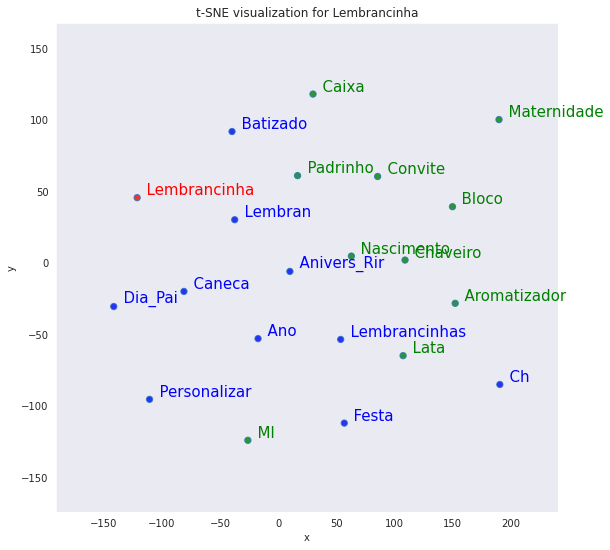

In [124]:
tsnescatterplot(w2v_model, "lembrancinha", [t[0] for t in w2v_model.wv.most_similar(positive=["lembrancinha"], topn=20)][10:])

# Personalizar x lembrancinha

Apesar da finalidade ser parecida e ainda apresentarem clusters de proxímos, intuitivamente para o usuário personalizar é inserir uma característica específica, seja em uma lembrancinha ou qualquer outro objeto. No entanto nem toda a escolha de um objeto poderá ter uma personalização, visto que em uma parcela de casos não há interesse do usuário.


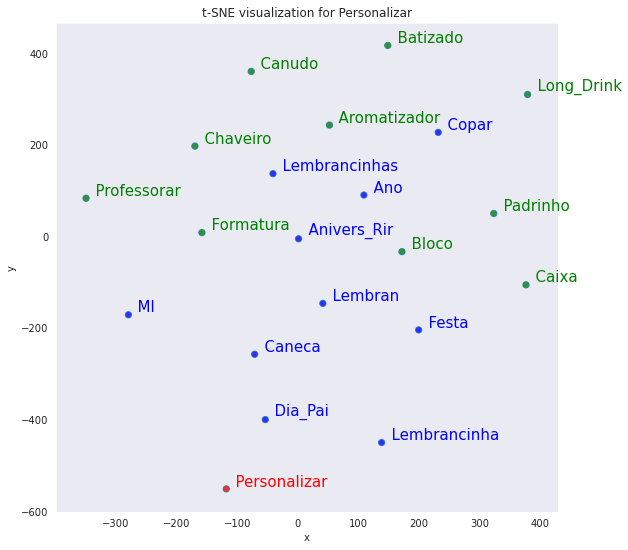

In [125]:

tsnescatterplot(w2v_model, 'personalizar', [t[0] for t in w2v_model.wv.most_similar(positive=['personalizar'], topn=20)][10:])